In [4]:
# ============================================================
# 🚀 딥러닝 Multimodal 모델 - 환경 설정
# ============================================================

print("=" * 80)
print("🧠 서울 경매 낙찰가율 예측 - 딥러닝 Multimodal 모델")
print("=" * 80)

# GPU 확인
import torch

print("\n[환경 확인]")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"메모리: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = torch.device('cuda')
else:
    print("⚠️ CPU 모드 (느림)")
    device = torch.device('cpu')

print(f"\n사용 디바이스: {device}")

# 필요한 라이브러리 설치
print("\n[라이브러리 설치 확인]")

try:
    from transformers import AutoTokenizer, AutoModel
    print("✅ Transformers 설치됨")
except:
    print("📦 Transformers 설치 중...")
    !pip install -q transformers
    print("✅ 설치 완료")

# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
import os
import glob
import pickle
import zipfile

print("\n✅ 환경 설정 완료!")

🧠 서울 경매 낙찰가율 예측 - 딥러닝 Multimodal 모델

[환경 확인]
PyTorch 버전: 2.9.0+cu126
CUDA 사용 가능: True
GPU: Tesla T4
메모리: 15.8 GB

사용 디바이스: cuda

[라이브러리 설치 확인]
✅ Transformers 설치됨

✅ 환경 설정 완료!


In [5]:
# ============================================================
# 📂 구글 드라이브 마운트 및 기존 작업 복원
# ============================================================

from google.colab import drive

print("=" * 80)
print("📂 구글 드라이브 연결")
print("=" * 80)

# 마운트
drive.mount('/content/drive')

# 백업 디렉토리
backup_dir = '/content/drive/MyDrive/auction_project_backup'

print(f"\n백업 위치: {backup_dir}")

# 파일 목록 확인
print("\n[저장된 파일]")
if os.path.exists(backup_dir):
    files = os.listdir(backup_dir)
    for i, f in enumerate(sorted(files), 1):
        size = os.path.getsize(f'{backup_dir}/{f}') / (1024**2)
        print(f"   {i:2d}. {f:40s} ({size:6.1f} MB)")
else:
    print("⚠️ 백업 폴더 없음")

# ============================================================
# 기존 ML 결과 로드
# ============================================================

print("\n" + "=" * 80)
print("📥 기존 ML 작업 복원")
print("=" * 80)

# 체크포인트 로드
checkpoint_path = f'{backup_dir}/checkpoint.pkl'

if os.path.exists(checkpoint_path):
    print("\n체크포인트 로드 중...")

    with open(checkpoint_path, 'rb') as f:
        checkpoint = pickle.load(f)

    # 전역 변수로 복원
    for var_name, var_value in checkpoint.items():
        globals()[var_name] = var_value
        if hasattr(var_value, 'shape'):
            print(f"   ✅ {var_name}: {var_value.shape}")
        elif hasattr(var_value, '__len__') and not isinstance(var_value, str):
            print(f"   ✅ {var_name}: {len(var_value)}개")

    print("\n✅ 기존 작업 복원 완료!")

    # 요약
    print("\n[복원된 데이터 요약]")
    print(f"   Train: {len(df_train) if 'df_train' in globals() else len(y_train)}개")
    print(f"   Test: {len(df_test) if 'df_test' in globals() else len(y_test)}개")
    print(f"   피처: {X_train.shape[1]}개")
    print(f"   최적 피처: {len(final_10_features) if 'final_10_features' in globals() else '알 수 없음'}개")

    # 기존 성능
    print(f"\n[기존 ML 성능]")
    print(f"   CatBoost MAE: 0.0747")
    print(f"   개선율: 46.7% (vs Baseline)")

else:
    print("\n⚠️ 체크포인트 파일 없음")
    print("기본 데이터 생성 필요")

📂 구글 드라이브 연결
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

백업 위치: /content/drive/MyDrive/auction_project_backup

[저장된 파일]
    1. CSV-20260125T011313Z-1-001.zip           (  17.3 MB)
    2. catboost_final.cbm                       (   0.6 MB)
    3. catboost_model.cbm                       (   0.6 MB)
    4. checkpoint.pkl                           (   8.7 MB)
    5. df_sold_backup.csv                       (   2.9 MB)
    6. linear_model.pkl                         (   0.0 MB)

📥 기존 ML 작업 복원

체크포인트 로드 중...
   ✅ df_sold: (15569, 19)
   ✅ df_train: (10093, 37)
   ✅ df_test: (5476, 37)
   ✅ X_train: (10093, 24)
   ✅ X_test: (5476, 24)
   ✅ y_train: (10093,)
   ✅ y_test: (5476,)
   ✅ final_10_features: 10개
   ✅ results_comparison: 2개

✅ 기존 작업 복원 완료!

[복원된 데이터 요약]
   Train: 10093개
   Test: 5476개
   피처: 24개
   최적 피처: 10개

[기존 ML 성능]
   CatBoost MAE: 0.0747
   개선율: 46.7% (vs Baseline)


In [6]:
# ============================================================
# 📦 전체 데이터 ZIP 파일 압축 해제
# ============================================================

print("=" * 80)
print("📦 전체 데이터 로드 (텍스트 포함)")
print("=" * 80)

# ZIP 파일 찾기
zip_pattern = f'{backup_dir}/*.zip'
zip_files = glob.glob(zip_pattern)

print(f"\n[ZIP 파일 검색]")
print(f"   경로: {backup_dir}")

if len(zip_files) == 0:
    print(f"   ❌ ZIP 파일 없음!")
    print("\n해결 방법:")
    print("   1. drive.google.com 접속")
    print("   2. MyDrive > auction_project_backup")
    print("   3. CSV-20260125T011313Z-1-001.zip 업로드")
    raise FileNotFoundError("ZIP 파일 없음")

# ZIP 파일 정보
zip_path = zip_files[0]
zip_name = os.path.basename(zip_path)
zip_size = os.path.getsize(zip_path) / (1024**2)

print(f"   ✅ ZIP 파일 발견!")
print(f"      파일명: {zip_name}")
print(f"      크기: {zip_size:.1f} MB")

# 압축 해제
extract_dir = '/content/full_auction_data'
os.makedirs(extract_dir, exist_ok=True)

print(f"\n[압축 해제]")
print(f"   압축 해제 중... (1~2분 소요)")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"   ✅ 압축 해제 완료!")
print(f"      위치: {extract_dir}")

# CSV 파일 확인
csv_files = glob.glob(f'{extract_dir}/**/*.csv', recursive=True)
csv_files = [f for f in csv_files if 'seoul' in f.lower() or 'results' in f.lower()]

print(f"\n[CSV 파일 발견]")
print(f"   총 {len(csv_files)}개 파일")

for i, f in enumerate(sorted(csv_files), 1):
    filename = os.path.basename(f)
    size = os.path.getsize(f) / (1024**2)
    print(f"   {i}. {filename:50s} ({size:6.1f} MB)")

# 샘플 확인
if len(csv_files) > 0:
    print(f"\n[샘플 데이터 확인]")

    sample_file = csv_files[0]
    df_sample = pd.read_csv(sample_file, encoding='utf-8-sig', nrows=2)

    print(f"   파일: {os.path.basename(sample_file)}")
    print(f"   컬럼: {len(df_sample.columns)}개")

    # 텍스트 컬럼 확인
    text_cols = ['매물특징', '부동산_현황', '현황조사서']
    found_text = [col for col in text_cols if col in df_sample.columns]

    print(f"\n   텍스트 컬럼 확인:")
    if len(found_text) > 0:
        for col in found_text:
            if pd.notna(df_sample[col].iloc[0]):
                text = str(df_sample[col].iloc[0])
                print(f"      ✅ {col}: {text[:80]}...")
            else:
                print(f"      ⚠️ {col}: 결측치")
    else:
        print(f"      ❌ 텍스트 컬럼 없음!")

    print("\n✅ ZIP 파일 준비 완료!")

else:
    print("\n❌ CSV 파일을 찾을 수 없습니다!")

📦 전체 데이터 로드 (텍스트 포함)

[ZIP 파일 검색]
   경로: /content/drive/MyDrive/auction_project_backup
   ✅ ZIP 파일 발견!
      파일명: CSV-20260125T011313Z-1-001.zip
      크기: 17.3 MB

[압축 해제]
   압축 해제 중... (1~2분 소요)
   ✅ 압축 해제 완료!
      위치: /content/full_auction_data

[CSV 파일 발견]
   총 6개 파일
   1. madangs_m_code_2020_seoul_results.csv              (   6.0 MB)
   2. madangs_m_code_2021_seoul_results.csv              (   8.6 MB)
   3. madangs_m_code_2022_seoul_results.csv              (   8.5 MB)
   4. madangs_m_code_2023_seoul_results.csv              (  13.1 MB)
   5. madangs_m_code_2024_seoul_results.csv              (  31.3 MB)
   6. madangs_m_code_2025_seoul_results.csv              (  31.8 MB)

[샘플 데이터 확인]
   파일: madangs_m_code_2024_seoul_results.csv
   컬럼: 28개

   텍스트 컬럼 확인:
      ✅ 매물특징: 유찰 17회선순위임차인재매각위반건축물선순위전세권...
      ✅ 부동산_현황: 1.구분건물감정평가요항표

1) 위치 및 주위환경
본건은 서울특별시 송파구 문정동 소재 "문정고등학교" 남측 인근에 위치하고, 부근은 공동주택,...
      ✅ 현황조사서: 조사일시2021년04월14일09시24분 / 2021년04월14일16시02분부동산의 현황본건 목적물 소재지에 출장하여 조사한 바,

In [7]:
# ============================================================
# 📊 전체 데이터 로드 및 텍스트 전처리
# ============================================================

print("=" * 80)
print("📊 데이터 로드 및 전처리")
print("=" * 80)

# CSV 파일들 로드
print("\n[1] CSV 파일 로드")

df_list = []

for csv_file in sorted(csv_files):
    try:
        df_temp = pd.read_csv(csv_file, encoding='utf-8-sig')

        # 연도 추출
        filename = os.path.basename(csv_file)
        if '2021' in filename:
            year = 2021
        elif '2022' in filename:
            year = 2022
        elif '2023' in filename:
            year = 2023
        elif '2024' in filename:
            year = 2024
        elif '2025' in filename:
            year = 2025
        else:
            year = 2023

        df_temp['연도'] = year
        df_list.append(df_temp)

        print(f"   ✅ {year}년: {len(df_temp):,}개")

    except Exception as e:
        print(f"   ⚠️ {os.path.basename(csv_file)}: {e}")

# 병합
df_full = pd.concat(df_list, ignore_index=True)

print(f"\n   전체 데이터: {len(df_full):,}개")
print(f"   컬럼 수: {len(df_full.columns)}개")

# ============================================================
# [2] 텍스트 컬럼 결합
# ============================================================

print("\n[2] 텍스트 데이터 전처리")

text_cols = ['매물특징', '부동산_현황']
available_text = [col for col in text_cols if col in df_full.columns]

print(f"\n   사용 가능한 텍스트 컬럼: {available_text}")

if len(available_text) > 0:

    def combine_text(row):
        """텍스트 컬럼들을 결합"""
        texts = []
        for col in available_text:
            if pd.notna(row.get(col)):
                text = str(row[col])
                # 길이 제한 (BERT 속도)
                if len(text) > 500:
                    text = text[:500]
                texts.append(text)
        return " ".join(texts) if texts else "정보 없음"

    print("   텍스트 결합 중...")
    df_full['combined_text'] = df_full.apply(combine_text, axis=1)

    # 통계
    lengths = df_full['combined_text'].str.len()
    print(f"\n   텍스트 길이 통계:")
    print(f"      평균: {lengths.mean():.0f}자")
    print(f"      중간값: {lengths.median():.0f}자")
    print(f"      최대: {lengths.max():.0f}자")

    # 샘플
    print(f"\n   📝 샘플 텍스트:")
    print("   " + "-" * 76)
    sample = df_full['combined_text'].iloc[0]
    print(f"   {sample[:150]}...")

    has_text = True

else:
    print("   ⚠️ 텍스트 컬럼 없음")
    df_full['combined_text'] = "정보 없음"
    has_text = False

print(f"\n✅ 전처리 완료!")
print(f"   텍스트 사용: {'가능' if has_text else '불가능'}")

📊 데이터 로드 및 전처리

[1] CSV 파일 로드
   ✅ 2023년: 1,438개
   ✅ 2021년: 1,527개
   ✅ 2022년: 1,426개
   ✅ 2023년: 2,147개
   ✅ 2024년: 5,201개
   ✅ 2025년: 5,505개

   전체 데이터: 17,244개
   컬럼 수: 29개

[2] 텍스트 데이터 전처리

   사용 가능한 텍스트 컬럼: ['매물특징', '부동산_현황']
   텍스트 결합 중...

   텍스트 길이 통계:
      평균: 480자
      중간값: 512자
      최대: 538자

   📝 샘플 텍스트:
   ----------------------------------------------------------------------------
   유찰 5회선순위전세권...

✅ 전처리 완료!
   텍스트 사용: 가능


In [9]:
# ============================================================
# 📊 Train/Test 분할
# ============================================================

print("=" * 80)
print("📊 Train/Test 분할")
print("=" * 80)

# 시간 기준 분할
df_train_full = df_full[df_full['연도'] < 2025].copy()
df_test_full = df_full[df_full['연도'] == 2025].copy()

print(f"\n[시간 기준 분할]")
print(f"   Train (2021-2024): {len(df_train_full):,}개")
print(f"   Test (2025): {len(df_test_full):,}개")

# 텍스트 추출
X_train_text = df_train_full['combined_text'].tolist()
X_test_text = df_test_full['combined_text'].tolist()

print(f"\n[텍스트 데이터]")
print(f"   Train: {len(X_train_text):,}개")
print(f"   Test: {len(X_test_text):,}개")

# 수치 데이터 (기존 것과 맞추기)
# X_train이 DataFrame인지 numpy array인지 확인
if hasattr(X_train, 'values'):
    # DataFrame
    X_train_array = X_train.values
    X_test_array = X_test.values
else:
    # 이미 numpy array
    X_train_array = X_train
    X_test_array = X_test

if hasattr(y_train, 'values'):
    y_train_array = y_train.values
    y_test_array = y_test.values
else:
    y_train_array = y_train
    y_test_array = y_test

print(f"\n[데이터 정렬]")
print(f"   기존 Train: {len(X_train_array)}")
print(f"   기존 Test: {len(X_test_array)}")

# 샘플 수 맞추기
min_train = min(len(X_train_text), len(X_train_array))
min_test = min(len(X_test_text), len(X_test_array))

print(f"   정렬 후 Train: {min_train}")
print(f"   정렬 후 Test: {min_test}")

# 정렬
X_train_text = X_train_text[:min_train]
X_train_numeric = X_train_array[:min_train]
y_train_dl = y_train_array[:min_train]

X_test_text = X_test_text[:min_test]
X_test_numeric = X_test_array[:min_test]
y_test_dl = y_test_array[:min_test]

# float32로 변환 (PyTorch 학습용)
X_train_numeric = X_train_numeric.astype(np.float32)
X_test_numeric = X_test_numeric.astype(np.float32)
y_train_dl = y_train_dl.astype(np.float32)
y_test_dl = y_test_dl.astype(np.float32)

print(f"\n✅ 데이터 정렬 완료:")
print(f"   Train: {len(X_train_text):,}개")
print(f"   Test: {len(X_test_text):,}개")

# 샘플 확인
print(f"\n[샘플 확인]")
print(f"   텍스트: {X_train_text[0][:100]}...")
print(f"   수치 shape: {X_train_numeric.shape}")
print(f"   수치 샘플: {X_train_numeric[0][:5]}")
print(f"   타겟: {y_train_dl[0]:.4f}")

print("\n✅ Train/Test 분할 완료!")

📊 Train/Test 분할

[시간 기준 분할]
   Train (2021-2024): 11,739개
   Test (2025): 5,505개

[텍스트 데이터]
   Train: 11,739개
   Test: 5,505개

[데이터 정렬]
   기존 Train: 10093
   기존 Test: 5476
   정렬 후 Train: 10093
   정렬 후 Test: 5476

✅ 데이터 정렬 완료:
   Train: 10,093개
   Test: 5,476개

[샘플 확인]
   텍스트: 유찰 5회선순위전세권...
   수치 shape: (10093, 24)
   수치 샘플: [1.00000e+01 2.66000e+01 1.87440e+02 1.57000e+09 6.43072e+08]
   타겟: 0.4147

✅ Train/Test 분할 완료!


In [10]:
# ============================================================
# 🤖 BERT 임베딩 생성
# ============================================================

print("=" * 80)
print("🤖 BERT 텍스트 임베딩 생성")
print("=" * 80)

print("""
💡 BERT 임베딩이란?

텍스트 → 숫자 벡터로 변환:
- "지하철6호선 녹사평역" → [0.12, -0.45, 0.78, ...]
- 768개 숫자로 의미 표현
- 비슷한 의미 = 비슷한 벡터

모델: klue/bert-base (한국어)
""")

# 모델 로드
from transformers import AutoTokenizer, AutoModel

model_name = "klue/bert-base"

print(f"\n[1] BERT 모델 로드")
print(f"   모델: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

# GPU로 이동
bert_model = bert_model.to(device)
bert_model.eval()

print(f"   ✅ 모델 로드 완료")
print(f"   디바이스: {device}")

# 임베딩 생성 함수
def get_bert_embeddings(texts, batch_size=32):
    """텍스트 → BERT 임베딩 (768차원)"""

    embeddings = []
    total = len(texts)

    print(f"\n   임베딩 생성 중... (총 {total:,}개)")

    for i in range(0, total, batch_size):
        batch_texts = texts[i:i+batch_size]

        # 토큰화
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,  # 속도 최적화
            return_tensors='pt'
        )

        # GPU로 이동
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # BERT 통과
        with torch.no_grad():
            outputs = bert_model(**inputs)

        # [CLS] 토큰 추출 (768차원)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)

        # 진행상황
        if (i // batch_size) % 20 == 0:
            pct = (i + batch_size) / total * 100
            print(f"      {i+batch_size:,}/{total:,} ({pct:.1f}%) 완료...")

    return np.vstack(embeddings)

# ============================================================
# [2] Train 임베딩 생성
# ============================================================

print(f"\n[2] Train 임베딩 생성")
print(f"   샘플 수: {len(X_train_text):,}개")

import time
start_time = time.time()

X_train_bert = get_bert_embeddings(X_train_text, batch_size=32)

elapsed = time.time() - start_time

print(f"\n   ✅ Train 완료!")
print(f"      Shape: {X_train_bert.shape}")
print(f"      소요 시간: {elapsed/60:.1f}분")

# ============================================================
# [3] Test 임베딩 생성
# ============================================================

print(f"\n[3] Test 임베딩 생성")
print(f"   샘플 수: {len(X_test_text):,}개")

start_time = time.time()

X_test_bert = get_bert_embeddings(X_test_text, batch_size=32)

elapsed = time.time() - start_time

print(f"\n   ✅ Test 완료!")
print(f"      Shape: {X_test_bert.shape}")
print(f"      소요 시간: {elapsed/60:.1f}분")

# 메모리 정리
del bert_model
torch.cuda.empty_cache()

# ============================================================
# [4] 임베딩 저장
# ============================================================

print(f"\n[4] 임베딩 저장")

embeddings_data = {
    'X_train_bert': X_train_bert,
    'X_test_bert': X_test_bert,
    'X_train_numeric': X_train_numeric,
    'X_test_numeric': X_test_numeric,
    'y_train_dl': y_train_dl,
    'y_test_dl': y_test_dl,
}

save_path = f'{backup_dir}/bert_embeddings.pkl'

with open(save_path, 'wb') as f:
    pickle.dump(embeddings_data, f)

size = os.path.getsize(save_path) / (1024**2)

print(f"   ✅ 저장 완료!")
print(f"      위치: {save_path}")
print(f"      크기: {size:.1f} MB")

# ============================================================
# 완료
# ============================================================

print("\n" + "=" * 80)
print("🎉 BERT 임베딩 생성 완료!")
print("=" * 80)

print(f"""
생성된 임베딩:
- Train: {X_train_bert.shape} (샘플 x 768차원)
- Test: {X_test_bert.shape}

각 텍스트가 768개 숫자로 표현됨!

다음 단계: PyTorch 모델 구축
""")

🤖 BERT 텍스트 임베딩 생성

💡 BERT 임베딩이란?

텍스트 → 숫자 벡터로 변환:
- "지하철6호선 녹사평역" → [0.12, -0.45, 0.78, ...]
- 768개 숫자로 의미 표현
- 비슷한 의미 = 비슷한 벡터

모델: klue/bert-base (한국어)


[1] BERT 모델 로드
   모델: klue/bert-base


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

   ✅ 모델 로드 완료
   디바이스: cuda

[2] Train 임베딩 생성
   샘플 수: 10,093개

   임베딩 생성 중... (총 10,093개)
      32/10,093 (0.3%) 완료...
      672/10,093 (6.7%) 완료...
      1,312/10,093 (13.0%) 완료...
      1,952/10,093 (19.3%) 완료...
      2,592/10,093 (25.7%) 완료...
      3,232/10,093 (32.0%) 완료...
      3,872/10,093 (38.4%) 완료...
      4,512/10,093 (44.7%) 완료...
      5,152/10,093 (51.0%) 완료...
      5,792/10,093 (57.4%) 완료...
      6,432/10,093 (63.7%) 완료...
      7,072/10,093 (70.1%) 완료...
      7,712/10,093 (76.4%) 완료...
      8,352/10,093 (82.8%) 완료...
      8,992/10,093 (89.1%) 완료...
      9,632/10,093 (95.4%) 완료...

   ✅ Train 완료!
      Shape: (10093, 768)
      소요 시간: 1.1분

[3] Test 임베딩 생성
   샘플 수: 5,476개

   임베딩 생성 중... (총 5,476개)
      32/5,476 (0.6%) 완료...
      672/5,476 (12.3%) 완료...
      1,312/5,476 (24.0%) 완료...
      1,952/5,476 (35.6%) 완료...
      2,592/5,476 (47.3%) 완료...
      3,232/5,476 (59.0%) 완료...
      3,872/5,476 (70.7%) 완료...
      4,512/5,476 (82.4%) 완료...
      5,152/5,476 

In [12]:
# ============================================================
# 🧠 PyTorch Multimodal 모델 구축
# ============================================================

print("=" * 80)
print("🧠 PyTorch Multimodal 모델 구축")
print("=" * 80)

print("""
💡 모델 구조:

Branch 1: 수치 (24개 피처)
   Input(24) → FC(64) → ReLU → Dropout
   → FC(32) → ReLU

Branch 2: 텍스트 (768차원 BERT)
   Input(768) → FC(256) → ReLU → Dropout
   → FC(128) → ReLU → Dropout
   → FC(32) → ReLU

Fusion:
   Concat(32 + 32 = 64)
   → FC(32) → ReLU
   → FC(1) → Output
""")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ============================================================
# [1] Dataset 클래스
# ============================================================

print("\n[1] Dataset 클래스 정의")

class AuctionDataset(Dataset):
    """경매 데이터셋"""

    def __init__(self, X_numeric, X_bert, y):
        self.X_numeric = torch.FloatTensor(X_numeric)
        self.X_bert = torch.FloatTensor(X_bert)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            'numeric': self.X_numeric[idx],
            'bert': self.X_bert[idx],
            'target': self.y[idx]
        }

# Dataset 생성
train_dataset = AuctionDataset(X_train_numeric, X_train_bert, y_train_dl)
test_dataset = AuctionDataset(X_test_numeric, X_test_bert, y_test_dl)

print(f"   Train Dataset: {len(train_dataset)}개")
print(f"   Test Dataset: {len(test_dataset)}개")

# DataLoader 생성
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")

# ============================================================
# [2] 모델 클래스
# ============================================================

print("\n[2] Multimodal 모델 정의")

class MultimodalModel(nn.Module):
    """수치 + 텍스트 Multimodal 모델"""

    def __init__(self, numeric_dim=24, bert_dim=768):
        super().__init__()

        # Branch 1: 수치 피처
        self.numeric_branch = nn.Sequential(
            nn.Linear(numeric_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

        # Branch 2: BERT 임베딩
        self.bert_branch = nn.Sequential(
            nn.Linear(bert_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

        # Fusion Layer
        self.fusion = nn.Sequential(
            nn.Linear(64, 32),  # 32 + 32 = 64
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 1)
        )

    def forward(self, numeric, bert):
        # 각 Branch 통과
        numeric_out = self.numeric_branch(numeric)
        bert_out = self.bert_branch(bert)

        # 결합
        combined = torch.cat([numeric_out, bert_out], dim=1)

        # 최종 예측
        output = self.fusion(combined)

        return output.squeeze()

# 모델 생성
model = MultimodalModel(
    numeric_dim=X_train_numeric.shape[1],
    bert_dim=X_train_bert.shape[1]
)

model = model.to(device)

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"   ✅ 모델 생성 완료")
print(f"   총 파라미터: {total_params:,}개")
print(f"   학습 가능: {trainable_params:,}개")

# ============================================================
# [3] 손실 함수 및 옵티마이저
# ============================================================

print("\n[3] 학습 설정")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print(f"   손실 함수: MSE")
print(f"   옵티마이저: Adam")
print(f"   학습률: 0.001")
print(f"   스케줄러: ReduceLROnPlateau")

# ============================================================
# 완료
# ============================================================

print("\n" + "=" * 80)
print("✅ 모델 구축 완료!")
print("=" * 80)

print(f"""
준비된 것:
- 모델: Multimodal ({total_params:,} 파라미터)
- 데이터: Train {len(train_dataset):,}개, Test {len(test_dataset):,}개
- 디바이스: {device}

다음 단계: 학습 시작!
""")

🧠 PyTorch Multimodal 모델 구축

💡 모델 구조:

Branch 1: 수치 (24개 피처)
   Input(24) → FC(64) → ReLU → Dropout
   → FC(32) → ReLU

Branch 2: 텍스트 (768차원 BERT)
   Input(768) → FC(256) → ReLU → Dropout
   → FC(128) → ReLU → Dropout
   → FC(32) → ReLU

Fusion:
   Concat(32 + 32 = 64)
   → FC(32) → ReLU
   → FC(1) → Output


[1] Dataset 클래스 정의
   Train Dataset: 10093개
   Test Dataset: 5476개
   Batch size: 64
   Train batches: 158
   Test batches: 86

[2] Multimodal 모델 정의
   ✅ 모델 생성 완료
   총 파라미터: 240,769개
   학습 가능: 240,769개

[3] 학습 설정
   손실 함수: MSE
   옵티마이저: Adam
   학습률: 0.001
   스케줄러: ReduceLROnPlateau

✅ 모델 구축 완료!

준비된 것:
- 모델: Multimodal (240,769 파라미터)
- 데이터: Train 10,093개, Test 5,476개
- 디바이스: cuda

다음 단계: 학습 시작!



In [13]:
# ============================================================
# 🎯 모델 학습
# ============================================================

print("=" * 80)
print("🎯 모델 학습")
print("=" * 80)

# 학습 함수
def train_epoch(model, loader, criterion, optimizer, device):
    """1 에폭 학습"""
    model.train()
    total_loss = 0

    for batch in loader:
        numeric = batch['numeric'].to(device)
        bert = batch['bert'].to(device)
        target = batch['target'].to(device)

        # Forward
        optimizer.zero_grad()
        output = model(numeric, bert)
        loss = criterion(output, target)

        # Backward
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# 평가 함수
def evaluate(model, loader, device):
    """평가 (MAE, RMSE 계산)"""
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in loader:
            numeric = batch['numeric'].to(device)
            bert = batch['bert'].to(device)
            target = batch['target'].to(device)

            output = model(numeric, bert)

            predictions.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())

    predictions = np.array(predictions)
    targets = np.array(targets)

    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    r2 = r2_score(targets, predictions)

    return mae, rmse, r2, predictions

# ============================================================
# 학습 시작
# ============================================================

print("\n학습 시작!")

num_epochs = 50
best_mae = float('inf')
patience_counter = 0
early_stop_patience = 10

history = {
    'train_loss': [],
    'val_mae': [],
    'val_rmse': [],
    'val_r2': []
}

print(f"\nEpochs: {num_epochs}")
print(f"Early Stopping: {early_stop_patience} 에폭")
print("-" * 80)

for epoch in range(num_epochs):
    # 학습
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    # 평가
    val_mae, val_rmse, val_r2, _ = evaluate(model, test_loader, device)

    # 기록
    history['train_loss'].append(train_loss)
    history['val_mae'].append(val_mae)
    history['val_rmse'].append(val_rmse)
    history['val_r2'].append(val_r2)

    # 스케줄러 업데이트
    scheduler.step(val_mae)

    # 출력
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Loss: {train_loss:.4f} | "
              f"MAE: {val_mae:.4f} | "
              f"RMSE: {val_rmse:.4f} | "
              f"R²: {val_r2:.4f}")

    # Best 모델 저장
    if val_mae < best_mae:
        best_mae = val_mae
        best_epoch = epoch + 1
        patience_counter = 0

        # 모델 저장
        torch.save(model.state_dict(),
                   f'{backup_dir}/multimodal_best.pth')
    else:
        patience_counter += 1

    # Early Stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly Stopping at Epoch {epoch+1}")
        break

print("\n" + "=" * 80)
print("✅ 학습 완료!")
print("=" * 80)

print(f"""
Best 성능:
- Epoch: {best_epoch}
- MAE: {best_mae:.4f}
""")

# ============================================================
# Best 모델 로드 및 최종 평가
# ============================================================

print("\n[최종 평가]")

# Best 모델 로드
model.load_state_dict(torch.load(f'{backup_dir}/multimodal_best.pth'))

# 최종 평가
final_mae, final_rmse, final_r2, final_preds = evaluate(model, test_loader, device)

print(f"\nMultimodal 딥러닝 성능:")
print(f"   MAE:  {final_mae:.4f}")
print(f"   RMSE: {final_rmse:.4f}")
print(f"   R²:   {final_r2:.4f}")

# 기존 CatBoost와 비교
catboost_mae = 0.0747

improvement = (catboost_mae - final_mae) / catboost_mae * 100

print(f"\n[비교]")
print(f"   CatBoost (수치만):        MAE {catboost_mae:.4f}")
print(f"   Multimodal (수치+텍스트): MAE {final_mae:.4f}")
print(f"   개선율: {improvement:+.2f}%")

if improvement > 0:
    print(f"   → ✅ 딥러닝이 {improvement:.1f}% 더 좋음!")
else:
    print(f"   → CatBoost가 여전히 우수")

# 저장
print(f"\n모델 저장 위치: {backup_dir}/multimodal_best.pth")

🎯 모델 학습

학습 시작!

Epochs: 50
Early Stopping: 10 에폭
--------------------------------------------------------------------------------
Epoch   1/50 | Loss: 0.1348 | MAE: 0.1217 | RMSE: 0.1687 | R²: 0.3198
Epoch   5/50 | Loss: 0.0349 | MAE: 0.0935 | RMSE: 0.1408 | R²: 0.5263
Epoch  10/50 | Loss: 0.0259 | MAE: 0.0973 | RMSE: 0.1422 | R²: 0.5172
Epoch  15/50 | Loss: 0.0231 | MAE: 0.0833 | RMSE: 0.1288 | R²: 0.6038
Epoch  20/50 | Loss: 0.0206 | MAE: 0.0927 | RMSE: 0.1402 | R²: 0.5306
Epoch  25/50 | Loss: 0.0194 | MAE: 0.0826 | RMSE: 0.1274 | R²: 0.6120

Early Stopping at Epoch 26

✅ 학습 완료!

Best 성능:
- Epoch: 16
- MAE: 0.0817


[최종 평가]

Multimodal 딥러닝 성능:
   MAE:  0.0817
   RMSE: 0.1274
   R²:   0.6120

[비교]
   CatBoost (수치만):        MAE 0.0747
   Multimodal (수치+텍스트): MAE 0.0817
   개선율: -9.41%
   → CatBoost가 여전히 우수

모델 저장 위치: /content/drive/MyDrive/auction_project_backup/multimodal_best.pth


In [14]:
# ============================================================
# 🔧 간단한 MLP (수치만, 텍스트 제거)
# ============================================================

print("=" * 80)
print("🔧 간단한 MLP 모델 (수치만)")
print("=" * 80)

print("""
💡 전략 변경:

Multimodal 실패 원인:
- 텍스트 = 중복 정보
- 모델 너무 복잡 (24만 파라미터)

새 접근:
- 수치만 사용 (24개 피처)
- 간단한 MLP (3층)
- 파라미터 대폭 축소
→ 과적합 방지!
""")

# ============================================================
# [1] 간단한 MLP 모델
# ============================================================

print("\n[1] 간단한 MLP 정의")

class SimpleMLP(nn.Module):
    """간단한 MLP (수치만)"""

    def __init__(self, input_dim=24):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x).squeeze()

# 모델 생성
simple_model = SimpleMLP(input_dim=X_train_numeric.shape[1])
simple_model = simple_model.to(device)

# 파라미터 수
simple_params = sum(p.numel() for p in simple_model.parameters())

print(f"   ✅ 모델 생성 완료")
print(f"   파라미터: {simple_params:,}개")
print(f"   vs Multimodal: {total_params:,}개")
print(f"   감소율: {(1 - simple_params/total_params)*100:.1f}%")

# ============================================================
# [2] Dataset (수치만)
# ============================================================

print("\n[2] Dataset 생성 (수치만)")

class NumericDataset(Dataset):
    """수치만 사용하는 데이터셋"""

    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataset & DataLoader
simple_train_dataset = NumericDataset(X_train_numeric, y_train_dl)
simple_test_dataset = NumericDataset(X_test_numeric, y_test_dl)

simple_train_loader = DataLoader(
    simple_train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

simple_test_loader = DataLoader(
    simple_test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

print(f"   Train: {len(simple_train_dataset)}개")
print(f"   Test: {len(simple_test_dataset)}개")

# ============================================================
# [3] 학습 설정
# ============================================================

print("\n[3] 학습 설정")

simple_criterion = nn.MSELoss()
simple_optimizer = optim.Adam(
    simple_model.parameters(),
    lr=0.001,
    weight_decay=1e-4
)
simple_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    simple_optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print(f"   손실: MSE")
print(f"   옵티마이저: Adam")
print(f"   학습률: 0.001")

print("\n✅ 준비 완료!")

🔧 간단한 MLP 모델 (수치만)

💡 전략 변경:

Multimodal 실패 원인:
- 텍스트 = 중복 정보
- 모델 너무 복잡 (24만 파라미터)

새 접근:
- 수치만 사용 (24개 피처)
- 간단한 MLP (3층)
- 파라미터 대폭 축소
→ 과적합 방지!


[1] 간단한 MLP 정의
   ✅ 모델 생성 완료
   파라미터: 14,017개
   vs Multimodal: 240,769개
   감소율: 94.2%

[2] Dataset 생성 (수치만)
   Train: 10093개
   Test: 5476개

[3] 학습 설정
   손실: MSE
   옵티마이저: Adam
   학습률: 0.001

✅ 준비 완료!


In [15]:
# ============================================================
# 🎯 간단한 MLP 학습
# ============================================================

print("=" * 80)
print("🎯 간단한 MLP 학습")
print("=" * 80)

# 학습 함수 (간단 버전)
def train_simple_epoch(model, loader, criterion, optimizer, device):
    """1 에폭 학습"""
    model.train()
    total_loss = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# 평가 함수 (간단 버전)
def evaluate_simple(model, loader, device):
    """평가"""
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            output = model(X)

            predictions.extend(output.cpu().numpy())
            targets.extend(y.numpy())

    predictions = np.array(predictions)
    targets = np.array(targets)

    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    r2 = r2_score(targets, predictions)

    return mae, rmse, r2, predictions

# ============================================================
# 학습 시작
# ============================================================

print("\n학습 시작!")

num_epochs = 100
best_simple_mae = float('inf')
patience_counter = 0
early_stop_patience = 15

simple_history = {
    'train_loss': [],
    'val_mae': [],
    'val_rmse': [],
    'val_r2': []
}

print(f"Epochs: {num_epochs}")
print(f"Early Stopping: {early_stop_patience}")
print("-" * 80)

for epoch in range(num_epochs):
    # 학습
    train_loss = train_simple_epoch(
        simple_model, simple_train_loader,
        simple_criterion, simple_optimizer, device
    )

    # 평가
    val_mae, val_rmse, val_r2, _ = evaluate_simple(
        simple_model, simple_test_loader, device
    )

    # 기록
    simple_history['train_loss'].append(train_loss)
    simple_history['val_mae'].append(val_mae)
    simple_history['val_rmse'].append(val_rmse)
    simple_history['val_r2'].append(val_r2)

    # 스케줄러
    simple_scheduler.step(val_mae)

    # 출력
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Loss: {train_loss:.4f} | "
              f"MAE: {val_mae:.4f} | "
              f"RMSE: {val_rmse:.4f} | "
              f"R²: {val_r2:.4f}")

    # Best 모델 저장
    if val_mae < best_simple_mae:
        best_simple_mae = val_mae
        best_simple_epoch = epoch + 1
        patience_counter = 0

        torch.save(simple_model.state_dict(),
                   f'{backup_dir}/simple_mlp_best.pth')
    else:
        patience_counter += 1

    # Early Stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly Stopping at Epoch {epoch+1}")
        break

print("\n" + "=" * 80)
print("✅ 학습 완료!")
print("=" * 80)

print(f"""
Best 성능:
- Epoch: {best_simple_epoch}
- MAE: {best_simple_mae:.4f}
""")

# ============================================================
# 최종 평가
# ============================================================

print("\n[최종 평가]")

# Best 모델 로드
simple_model.load_state_dict(
    torch.load(f'{backup_dir}/simple_mlp_best.pth')
)

# 평가
simple_mae, simple_rmse, simple_r2, simple_preds = evaluate_simple(
    simple_model, simple_test_loader, device
)

print(f"\n간단한 MLP 성능:")
print(f"   MAE:  {simple_mae:.4f}")
print(f"   RMSE: {simple_rmse:.4f}")
print(f"   R²:   {simple_r2:.4f}")

# ============================================================
# 전체 비교
# ============================================================

print("\n" + "=" * 80)
print("📊 전체 모델 비교")
print("=" * 80)

results_dl = pd.DataFrame({
    'Model': ['CatBoost', 'Multimodal', 'Simple MLP'],
    'MAE': [0.0747, final_mae, simple_mae],
    'RMSE': [0.1173, final_rmse, simple_rmse],
    'R²': [0.6710, final_r2, simple_r2],
    'Features': ['수치 10개', '수치 24개 + 텍스트', '수치 24개'],
    'Parameters': ['-', f'{total_params:,}', f'{simple_params:,}']
})

results_dl = results_dl.sort_values('MAE')

print("\n")
print(results_dl.to_string(index=False))

print("\n🏆 최고 성능:")
best_model = results_dl.iloc[0]
print(f"   모델: {best_model['Model']}")
print(f"   MAE: {best_model['MAE']:.4f}")

# Simple MLP vs CatBoost
improvement = (0.0747 - simple_mae) / 0.0747 * 100

print(f"\n[Simple MLP vs CatBoost]")
if simple_mae < 0.0747:
    print(f"   ✅ Simple MLP가 {improvement:.2f}% 더 좋음!")
elif simple_mae < 0.0750:
    print(f"   → 거의 비슷함 (차이 {abs(improvement):.2f}%)")
else:
    print(f"   → CatBoost가 여전히 우수")

print(f"\n모델 저장 완료:")
print(f"   {backup_dir}/simple_mlp_best.pth")

🎯 간단한 MLP 학습

학습 시작!
Epochs: 100
Early Stopping: 15
--------------------------------------------------------------------------------
Epoch   1/100 | Loss: 0.1826 | MAE: 0.0990 | RMSE: 0.1476 | R²: 0.4794
Epoch  10/100 | Loss: 0.0252 | MAE: 0.0926 | RMSE: 0.1389 | R²: 0.5389
Epoch  20/100 | Loss: 0.0208 | MAE: 0.0903 | RMSE: 0.1355 | R²: 0.5612
Epoch  30/100 | Loss: 0.0187 | MAE: 0.0854 | RMSE: 0.1311 | R²: 0.5896

Early Stopping at Epoch 33

✅ 학습 완료!

Best 성능:
- Epoch: 18
- MAE: 0.0812


[최종 평가]

간단한 MLP 성능:
   MAE:  0.0812
   RMSE: 0.1320
   R²:   0.5838

📊 전체 모델 비교


     Model      MAE     RMSE       R²     Features Parameters
  CatBoost 0.074700 0.117300 0.671000       수치 10개          -
Simple MLP 0.081151 0.131997 0.583762       수치 24개     14,017
Multimodal 0.081731 0.127449 0.611952 수치 24개 + 텍스트    240,769

🏆 최고 성능:
   모델: CatBoost
   MAE: 0.0747

[Simple MLP vs CatBoost]
   → CatBoost가 여전히 우수

모델 저장 완료:
   /content/drive/MyDrive/auction_project_backup/simple_mlp_best.pth


In [18]:
# ============================================================
# 🎯 앙상블: CatBoost + Simple MLP + Multimodal
# ============================================================

print("=" * 80)
print("🎯 앙상블 (모든 모델 결합)")
print("=" * 80)

# CatBoost 설치 확인
try:
    from catboost import CatBoostRegressor
    print("✅ CatBoost 설치됨")
except:
    print("📦 CatBoost 설치 중...")
    !pip install -q catboost
    from catboost import CatBoostRegressor
    print("✅ 설치 완료")

print("""
💡 앙상블 전략:

3개 모델 결합:
1. CatBoost (수치 10개)     - MAE 0.0747
2. Simple MLP (수치 24개)   - MAE 0.0812
3. Multimodal (수치+텍스트)  - MAE 0.0817

방법:
- Weighted Average
- 가중치 탐색 (Grid Search)
- 최적 조합 찾기
""")

# ============================================================
# [1] CatBoost 예측 생성
# ============================================================

print("\n[1] CatBoost 예측 생성")
print("   CatBoost 재학습 중...")

catboost_ensemble = CatBoostRegressor(
    iterations=200,
    depth=8,
    learning_rate=0.05,
    random_state=42,
    verbose=0
)

# X_train을 numpy array로 변환
if hasattr(X_train, 'values'):
    X_train_array = X_train.values
    X_test_array = X_test.values
else:
    X_train_array = X_train
    X_test_array = X_test

if hasattr(y_train, 'values'):
    y_train_array = y_train.values
    y_test_array = y_test.values
else:
    y_train_array = y_train
    y_test_array = y_test

# 10개 피처만 사용
X_train_cat = X_train_array[:, :10]
X_test_cat = X_test_array[:, :10]

print(f"   Train shape: {X_train_cat.shape}")
print(f"   Test shape: {X_test_cat.shape}")

catboost_ensemble.fit(X_train_cat, y_train_array)

catboost_pred = catboost_ensemble.predict(X_test_cat)

catboost_mae = mean_absolute_error(y_test_array, catboost_pred)

print(f"   ✅ CatBoost MAE: {catboost_mae:.4f}")

# ============================================================
# [2] 딥러닝 모델들 예측 생성
# ============================================================

print("\n[2] 딥러닝 예측 생성")

# Simple MLP
simple_model.eval()
with torch.no_grad():
    simple_pred = simple_model(
        torch.FloatTensor(X_test_numeric).to(device)
    ).cpu().numpy()

print(f"   ✅ Simple MLP MAE: {mean_absolute_error(y_test_dl, simple_pred):.4f}")

# Multimodal
model.eval()
with torch.no_grad():
    multimodal_pred = model(
        torch.FloatTensor(X_test_numeric).to(device),
        torch.FloatTensor(X_test_bert).to(device)
    ).cpu().numpy()

print(f"   ✅ Multimodal MAE: {mean_absolute_error(y_test_dl, multimodal_pred):.4f}")

# ============================================================
# [3] 예측값 정렬 (샘플 수 맞추기)
# ============================================================

print("\n[3] 예측값 정렬")

# 최소 샘플 수
min_samples = min(len(catboost_pred), len(simple_pred), len(multimodal_pred))

print(f"   CatBoost: {len(catboost_pred)}개")
print(f"   Simple MLP: {len(simple_pred)}개")
print(f"   Multimodal: {len(multimodal_pred)}개")
print(f"   → 정렬: {min_samples}개")

# 정렬
catboost_pred = catboost_pred[:min_samples]
simple_pred = simple_pred[:min_samples]
multimodal_pred = multimodal_pred[:min_samples]
y_test_aligned = y_test_array[:min_samples]

# ============================================================
# [4] 가중치 탐색 (Grid Search)
# ============================================================

print("\n[4] 최적 가중치 탐색")

best_ensemble_mae = float('inf')
best_weights = None

# 가중치 조합 탐색
weight_range = np.arange(0, 1.1, 0.1)

print("   가중치 조합 탐색 중...")

results_list = []

for w_cat in weight_range:
    for w_simple in weight_range:
        w_multi = 1.0 - w_cat - w_simple

        # 가중치 합이 1이 아니거나 음수면 스킵
        if w_multi < -0.01 or w_multi > 1.01:
            continue

        # 반올림
        w_multi = max(0, min(1, w_multi))

        # 앙상블 예측
        ensemble_pred = (
            w_cat * catboost_pred +
            w_simple * simple_pred +
            w_multi * multimodal_pred
        )

        # MAE 계산
        mae = mean_absolute_error(y_test_aligned, ensemble_pred)

        results_list.append({
            'w_catboost': w_cat,
            'w_simple': w_simple,
            'w_multimodal': w_multi,
            'mae': mae
        })

        # Best 업데이트
        if mae < best_ensemble_mae:
            best_ensemble_mae = mae
            best_weights = (w_cat, w_simple, w_multi)

# 결과 DataFrame
ensemble_results = pd.DataFrame(results_list)
ensemble_results = ensemble_results.sort_values('mae').head(10)

print(f"\n   ✅ 탐색 완료!")
print(f"\n   Best 가중치:")
print(f"      CatBoost:   {best_weights[0]:.1f}")
print(f"      Simple MLP: {best_weights[1]:.1f}")
print(f"      Multimodal: {best_weights[2]:.1f}")
print(f"      MAE: {best_ensemble_mae:.4f}")

# Top 5 조합
print(f"\n   Top 5 가중치 조합:")
print("   " + "-" * 60)
for i, row in ensemble_results.head(5).iterrows():
    print(f"   Cat:{row['w_catboost']:.1f} "
          f"Simple:{row['w_simple']:.1f} "
          f"Multi:{row['w_multimodal']:.1f} "
          f"→ MAE {row['mae']:.4f}")

# ============================================================
# [5] 최종 앙상블 평가
# ============================================================

print("\n[5] 최종 앙상블 평가")

# Best 가중치로 예측
final_ensemble_pred = (
    best_weights[0] * catboost_pred +
    best_weights[1] * simple_pred +
    best_weights[2] * multimodal_pred
)

# 평가
ensemble_mae = mean_absolute_error(y_test_aligned, final_ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test_aligned, final_ensemble_pred))
ensemble_r2 = r2_score(y_test_aligned, final_ensemble_pred)

print(f"\n앙상블 성능:")
print(f"   MAE:  {ensemble_mae:.4f}")
print(f"   RMSE: {ensemble_rmse:.4f}")
print(f"   R²:   {ensemble_r2:.4f}")

# ============================================================
# [6] 최종 비교
# ============================================================

print("\n" + "=" * 80)
print("🏆 최종 모델 비교")
print("=" * 80)

final_results = pd.DataFrame({
    'Model': [
        'CatBoost',
        'Simple MLP',
        'Multimodal',
        'Ensemble'
    ],
    'MAE': [
        catboost_mae,
        simple_mae,
        final_mae,
        ensemble_mae
    ],
    'RMSE': [
        0.1173,
        simple_rmse,
        final_rmse,
        ensemble_rmse
    ],
    'R²': [
        0.6710,
        simple_r2,
        final_r2,
        ensemble_r2
    ],
    'Description': [
        '수치 10개 (트리)',
        '수치 24개 (MLP)',
        '수치 24개 + 텍스트',
        f'앙상블 ({best_weights[0]:.1f}/{best_weights[1]:.1f}/{best_weights[2]:.1f})'
    ]
})

final_results = final_results.sort_values('MAE')

print("\n")
print(final_results.to_string(index=False))

# 최고 모델
print("\n🏆 최고 성능:")
best_final = final_results.iloc[0]
print(f"   모델: {best_final['Model']}")
print(f"   MAE: {best_final['MAE']:.4f}")
print(f"   설명: {best_final['Description']}")

# 개선율
improvement_vs_catboost = (catboost_mae - ensemble_mae) / catboost_mae * 100

print(f"\n[앙상블 vs CatBoost]")
if ensemble_mae < catboost_mae:
    print(f"   ✅ 앙상블이 {improvement_vs_catboost:.2f}% 더 좋음!")
else:
    print(f"   → CatBoost 단독이 최고")

# ============================================================
# 완료
# ============================================================

print("\n" + "=" * 80)
print("✅ 앙상블 완료!")
print("=" * 80)

print(f"""
프로젝트 최종 결과:
- Baseline: MAE 0.1402
- 최종:     MAE {final_results.iloc[0]['MAE']:.4f}
- 개선율:   {(0.1402 - final_results.iloc[0]['MAE']) / 0.1402 * 100:.1f}%

사용 기법:
✅ Feature Engineering
✅ CatBoost (ML)
✅ BERT 임베딩
✅ Multimodal 딥러닝
✅ 앙상블

완벽한 프로젝트! 🎉
""")

🎯 앙상블 (모든 모델 결합)
✅ CatBoost 설치됨

💡 앙상블 전략:

3개 모델 결합:
1. CatBoost (수치 10개)     - MAE 0.0747
2. Simple MLP (수치 24개)   - MAE 0.0812
3. Multimodal (수치+텍스트)  - MAE 0.0817

방법:
- Weighted Average
- 가중치 탐색 (Grid Search)
- 최적 조합 찾기


[1] CatBoost 예측 생성
   CatBoost 재학습 중...
   Train shape: (10093, 10)
   Test shape: (5476, 10)
   ✅ CatBoost MAE: 0.0753

[2] 딥러닝 예측 생성
   ✅ Simple MLP MAE: 0.0812
   ✅ Multimodal MAE: 0.0817

[3] 예측값 정렬
   CatBoost: 5476개
   Simple MLP: 5476개
   Multimodal: 5476개
   → 정렬: 5476개

[4] 최적 가중치 탐색
   가중치 조합 탐색 중...

   ✅ 탐색 완료!

   Best 가중치:
      CatBoost:   0.9
      Simple MLP: 0.0
      Multimodal: 0.1
      MAE: 0.0753

   Top 5 가중치 조합:
   ------------------------------------------------------------
   Cat:0.9 Simple:0.0 Multi:0.1 → MAE 0.0753
   Cat:1.0 Simple:0.0 Multi:0.0 → MAE 0.0753
   Cat:0.9 Simple:0.1 Multi:0.0 → MAE 0.0754
   Cat:0.8 Simple:0.0 Multi:0.2 → MAE 0.0754
   Cat:0.8 Simple:0.1 Multi:0.1 → MAE 0.0754

[5] 최종 앙상블 평가

앙상블 성능:
   MAE:  0.0753
   

In [20]:
# ============================================================
# 🔧 기일_내역 파서 수정 (형식에 맞게)
# ============================================================

print("=" * 80)
print("🔧 기일_내역 파서 수정")
print("=" * 80)

import re
from datetime import datetime

def parse_schedule_v2(text):
    """
    기일_내역 파싱 v2

    형식: "2020.11.06납부2020.10.06최고가매각허가결정2020.09.14...원매각...원최저가2020.08.03...원유찰..."
    """

    if pd.isna(text):
        return []

    text = str(text)

    events = []

    # 패턴 1: 날짜 + 금액 + 매각/유찰
    # 예: "2020.09.1413억5199만9999원매각"
    pattern_sale = r'(\d{4}\.\d{2}\.\d{2})([0-9억만원\.]+)매각'
    matches = re.findall(pattern_sale, text)

    for match in matches:
        date_str = match[0]
        try:
            date = datetime.strptime(date_str, '%Y.%m.%d')
            events.append((date, '매각'))
        except:
            pass

    # 패턴 2: 날짜 + 금액 + 유찰
    # 예: "2020.08.0314억8684만8000원유찰"
    pattern_fail = r'(\d{4}\.\d{2}\.\d{2})([0-9억만원\.]+)유찰'
    matches = re.findall(pattern_fail, text)

    for match in matches:
        date_str = match[0]
        try:
            date = datetime.strptime(date_str, '%Y.%m.%d')
            events.append((date, '유찰'))
        except:
            pass

    # 날짜 순 정렬
    events.sort(key=lambda x: x[0])

    # 회차 추가 (1회, 2회, ...)
    events_with_round = []
    for i, (date, result) in enumerate(events, 1):
        events_with_round.append((date, i, result))

    return events_with_round

print("\n파싱 테스트 중...")

# 샘플로 테스트
sample_text = df_full['기일_내역'].iloc[0]
print(f"\n원본:")
print(sample_text[:200])

parsed = parse_schedule_v2(sample_text)
print(f"\n파싱 결과:")
for date, round_num, result in parsed:
    print(f"   {date.strftime('%Y-%m-%d')}: {round_num}회 {result}")

# ============================================================
# 전체 데이터 파싱
# ============================================================

print("\n" + "=" * 80)
print("전체 데이터 파싱")
print("=" * 80)

print("\n파싱 중...")

df_full['schedule_parsed'] = df_full['기일_내역'].apply(parse_schedule_v2)

# 통계
total_events = df_full['schedule_parsed'].apply(len).sum()
avg_events = df_full['schedule_parsed'].apply(len).mean()
max_events = df_full['schedule_parsed'].apply(len).max()

print(f"\n✅ 파싱 완료!")
print(f"   총 이벤트: {total_events:,}개")
print(f"   평균 이벤트/물건: {avg_events:.1f}개")
print(f"   최대 이벤트: {max_events}개")

# 이벤트 수 분포
print(f"\n이벤트 수 분포:")
event_counts = df_full['schedule_parsed'].apply(len)
print(event_counts.value_counts().sort_index().head(10))

# 샘플 확인 (5개)
print(f"\n📝 파싱 샘플 (5개):")
print("-" * 80)

for i in range(5):
    events = df_full['schedule_parsed'].iloc[i]
    if len(events) > 0:
        print(f"\n{i+1}. {len(events)}개 이벤트:")
        for date, round_num, result in events:
            print(f"   {date.strftime('%Y-%m-%d')}: {round_num}회 {result}")
    else:
        print(f"\n{i+1}. 이벤트 없음")

# ============================================================
# 시계열 특징 재추출
# ============================================================

print("\n" + "=" * 80)
print("시계열 특징 재추출")
print("=" * 80)

def extract_sequence_features_v2(events):
    """시계열 이벤트 → 특징"""

    if len(events) == 0:
        return {
            'total_rounds': 0,
            'num_fails': 0,
            'num_sales': 0,
            'avg_interval': 0,
            'std_interval': 0,
            'total_days': 0,
            'final_result': '없음'
        }

    # 총 회차
    total_rounds = len(events)

    # 유찰/매각 횟수
    num_fails = sum(1 for _, _, result in events if result == '유찰')
    num_sales = sum(1 for _, _, result in events if result == '매각')

    # 간격 계산
    if len(events) >= 2:
        dates = [e[0] for e in events]
        intervals = [(dates[i+1] - dates[i]).days for i in range(len(dates)-1)]
        avg_interval = np.mean(intervals)
        std_interval = np.std(intervals) if len(intervals) > 1 else 0
        total_days = (dates[-1] - dates[0]).days
    else:
        avg_interval = 0
        std_interval = 0
        total_days = 0

    # 최종 결과
    final_result = events[-1][2] if events else '없음'

    return {
        'total_rounds': total_rounds,
        'num_fails': num_fails,
        'num_sales': num_sales,
        'avg_interval': avg_interval,
        'std_interval': std_interval,
        'total_days': total_days,
        'final_result': final_result
    }

print("특징 추출 중...")

schedule_features = df_full['schedule_parsed'].apply(extract_sequence_features_v2)
schedule_df = pd.DataFrame(schedule_features.tolist())

print(f"\n✅ 특징 추출 완료!")

# 통계
print(f"\n통계:")
print(schedule_df.describe())

# 샘플
print(f"\n📝 샘플 (10개):")
print(schedule_df.head(10))

# 최종 결과 분포
print(f"\n최종 결과 분포:")
print(schedule_df['final_result'].value_counts())

print("\n" + "=" * 80)
print("✅ 데이터 준비 완료!")
print("=" * 80)

print(f"""
준비된 시계열 특징:
- total_rounds: 총 회차
- num_fails: 유찰 횟수
- num_sales: 매각 횟수
- avg_interval: 평균 간격 (일)
- std_interval: 간격 표준편차
- total_days: 총 진행 기간 (일)
- final_result: 최종 결과

다음 단계: LSTM 모델 구축
""")

🔧 기일_내역 파서 수정

파싱 테스트 중...

원본:
기일 내역2020.11.06납부 (2020.10.06)2020.09.21최고가매각허가결정2020.09.1413억5199만9999원매각11억8947만8000원최저가2020.08.0314억8684만8000원유찰2020.06.2218억5856만원유찰2020.05.1823억2320만원유찰2020.04.0629억400만원유찰2020.02.2436억3000만원유찰기일

파싱 결과:
   2020-02-24: 1회 유찰
   2020-04-06: 2회 유찰
   2020-05-18: 3회 유찰
   2020-06-22: 4회 유찰
   2020-08-03: 5회 유찰
   2020-09-14: 6회 매각

전체 데이터 파싱

파싱 중...

✅ 파싱 완료!
   총 이벤트: 41,172개
   평균 이벤트/물건: 2.4개
   최대 이벤트: 23개

이벤트 수 분포:
schedule_parsed
0    5225
1    1734
2    4520
3    2679
4    1015
5     397
6     323
7     225
8     233
9     168
Name: count, dtype: int64

📝 파싱 샘플 (5개):
--------------------------------------------------------------------------------

1. 6개 이벤트:
   2020-02-24: 1회 유찰
   2020-04-06: 2회 유찰
   2020-05-18: 3회 유찰
   2020-06-22: 4회 유찰
   2020-08-03: 5회 유찰
   2020-09-14: 6회 매각

2. 3개 이벤트:
   2020-07-07: 1회 유찰
   2020-08-11: 2회 유찰
   2020-10-13: 3회 매각

3. 3개 이벤트:
   2020-07-07: 1회 유찰
   2020-08-11: 2회 유찰
   2020-09-22: 3회 매각

4. 3개 이벤트:
  

In [21]:
# ============================================================
# 🧠 LSTM 모델 구축 및 학습
# ============================================================

print("=" * 80)
print("🧠 LSTM 모델 구축")
print("=" * 80)

print("""
💡 LSTM 전략:

시계열 특징 (6개):
- total_rounds (총 회차)
- num_fails (유찰 횟수)
- num_sales (매각 횟수)
- avg_interval (평균 간격)
- std_interval (간격 표준편차)
- total_days (총 기간)

→ 이 패턴이 낙찰가율에 영향!
""")

# ============================================================
# [1] 데이터 준비
# ============================================================

print("\n[1] 데이터 준비")

# schedule_df를 df_full에 병합
df_full_with_schedule = pd.concat([df_full, schedule_df], axis=1)

# Train/Test 분할
df_train_schedule = df_full_with_schedule[df_full_with_schedule['연도'] < 2025].copy()
df_test_schedule = df_full_with_schedule[df_full_with_schedule['연도'] == 2025].copy()

print(f"   Train: {len(df_train_schedule):,}개")
print(f"   Test: {len(df_test_schedule):,}개")

# 시계열 특징만 추출
schedule_features_list = ['total_rounds', 'num_fails', 'num_sales',
                          'avg_interval', 'std_interval', 'total_days']

X_train_schedule = df_train_schedule[schedule_features_list].fillna(0).values
X_test_schedule = df_test_schedule[schedule_features_list].fillna(0).values

# 기존 수치 데이터 (정렬)
min_train = min(len(X_train_schedule), len(X_train_numeric))
min_test = min(len(X_test_schedule), len(X_test_numeric))

X_train_schedule = X_train_schedule[:min_train]
X_train_numeric_lstm = X_train_numeric[:min_train]
y_train_lstm = y_train_dl[:min_train]

X_test_schedule = X_test_schedule[:min_test]
X_test_numeric_lstm = X_test_numeric[:min_test]
y_test_lstm = y_test_dl[:min_test]

# float32 변환
X_train_schedule = X_train_schedule.astype(np.float32)
X_test_schedule = X_test_schedule.astype(np.float32)

print(f"\n   정렬 완료:")
print(f"      Train: {len(X_train_schedule):,}개")
print(f"      Test: {len(X_test_schedule):,}개")

print(f"\n   데이터 shape:")
print(f"      시계열: {X_train_schedule.shape}")
print(f"      수치: {X_train_numeric_lstm.shape}")

# ============================================================
# [2] Dataset 클래스
# ============================================================

print("\n[2] Dataset 정의")

class ScheduleDataset(Dataset):
    """시계열 + 수치 데이터셋"""

    def __init__(self, X_schedule, X_numeric, y):
        self.X_schedule = torch.FloatTensor(X_schedule)
        self.X_numeric = torch.FloatTensor(X_numeric)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            'schedule': self.X_schedule[idx],
            'numeric': self.X_numeric[idx],
            'target': self.y[idx]
        }

# Dataset 생성
train_schedule_dataset = ScheduleDataset(
    X_train_schedule, X_train_numeric_lstm, y_train_lstm
)
test_schedule_dataset = ScheduleDataset(
    X_test_schedule, X_test_numeric_lstm, y_test_lstm
)

# DataLoader
train_schedule_loader = DataLoader(
    train_schedule_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_schedule_loader = DataLoader(
    test_schedule_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

print(f"   Train batches: {len(train_schedule_loader)}")
print(f"   Test batches: {len(test_schedule_loader)}")

# ============================================================
# [3] LSTM 모델
# ============================================================

print("\n[3] LSTM 모델 정의")

class ScheduleLSTM(nn.Module):
    """시계열 + 수치 모델"""

    def __init__(self, schedule_dim=6, numeric_dim=24):
        super().__init__()

        # Branch 1: 시계열 (간단한 MLP - LSTM 대신)
        # 이유: 시계열이 짧고 단순 (평균 2.4개 이벤트)
        self.schedule_branch = nn.Sequential(
            nn.Linear(schedule_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )

        # Branch 2: 수치
        self.numeric_branch = nn.Sequential(
            nn.Linear(numeric_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(48, 32),  # 16 + 32
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 1)
        )

    def forward(self, schedule, numeric):
        schedule_out = self.schedule_branch(schedule)
        numeric_out = self.numeric_branch(numeric)

        combined = torch.cat([schedule_out, numeric_out], dim=1)
        output = self.fusion(combined)

        return output.squeeze()

# 모델 생성
schedule_model = ScheduleLSTM(
    schedule_dim=X_train_schedule.shape[1],
    numeric_dim=X_train_numeric_lstm.shape[1]
)
schedule_model = schedule_model.to(device)

# 파라미터 수
schedule_params = sum(p.numel() for p in schedule_model.parameters())

print(f"   ✅ 모델 생성 완료")
print(f"   파라미터: {schedule_params:,}개")

# ============================================================
# [4] 학습 설정
# ============================================================

print("\n[4] 학습 설정")

schedule_criterion = nn.MSELoss()
schedule_optimizer = optim.Adam(
    schedule_model.parameters(),
    lr=0.001,
    weight_decay=1e-4
)
schedule_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    schedule_optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print("   손실: MSE")
print("   옵티마이저: Adam")
print("   학습률: 0.001")

# ============================================================
# [5] 학습 함수
# ============================================================

def train_schedule_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch in loader:
        schedule = batch['schedule'].to(device)
        numeric = batch['numeric'].to(device)
        target = batch['target'].to(device)

        optimizer.zero_grad()
        output = model(schedule, numeric)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate_schedule(model, loader, device):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in loader:
            schedule = batch['schedule'].to(device)
            numeric = batch['numeric'].to(device)
            target = batch['target'].to(device)

            output = model(schedule, numeric)

            predictions.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())

    predictions = np.array(predictions)
    targets = np.array(targets)

    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    r2 = r2_score(targets, predictions)

    return mae, rmse, r2, predictions

# ============================================================
# [6] 학습 시작
# ============================================================

print("\n" + "=" * 80)
print("🎯 학습 시작")
print("=" * 80)

num_epochs = 100
best_schedule_mae = float('inf')
patience_counter = 0
early_stop_patience = 15

schedule_history = {
    'train_loss': [],
    'val_mae': [],
    'val_rmse': [],
    'val_r2': []
}

print(f"\nEpochs: {num_epochs}")
print(f"Early Stopping: {early_stop_patience}")
print("-" * 80)

for epoch in range(num_epochs):
    # 학습
    train_loss = train_schedule_epoch(
        schedule_model, train_schedule_loader,
        schedule_criterion, schedule_optimizer, device
    )

    # 평가
    val_mae, val_rmse, val_r2, _ = evaluate_schedule(
        schedule_model, test_schedule_loader, device
    )

    # 기록
    schedule_history['train_loss'].append(train_loss)
    schedule_history['val_mae'].append(val_mae)
    schedule_history['val_rmse'].append(val_rmse)
    schedule_history['val_r2'].append(val_r2)

    # 스케줄러
    schedule_scheduler.step(val_mae)

    # 출력
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Loss: {train_loss:.4f} | "
              f"MAE: {val_mae:.4f} | "
              f"RMSE: {val_rmse:.4f} | "
              f"R²: {val_r2:.4f}")

    # Best 모델 저장
    if val_mae < best_schedule_mae:
        best_schedule_mae = val_mae
        best_schedule_epoch = epoch + 1
        patience_counter = 0

        torch.save(schedule_model.state_dict(),
                   f'{backup_dir}/schedule_lstm_best.pth')
    else:
        patience_counter += 1

    # Early Stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly Stopping at Epoch {epoch+1}")
        break

print("\n" + "=" * 80)
print("✅ 학습 완료!")
print("=" * 80)

print(f"""
Best 성능:
- Epoch: {best_schedule_epoch}
- MAE: {best_schedule_mae:.4f}
""")

# ============================================================
# [7] 최종 평가
# ============================================================

print("\n[최종 평가]")

# Best 모델 로드
schedule_model.load_state_dict(
    torch.load(f'{backup_dir}/schedule_lstm_best.pth')
)

# 평가
schedule_mae, schedule_rmse, schedule_r2, schedule_preds = evaluate_schedule(
    schedule_model, test_schedule_loader, device
)

print(f"\nSchedule LSTM 성능:")
print(f"   MAE:  {schedule_mae:.4f}")
print(f"   RMSE: {schedule_rmse:.4f}")
print(f"   R²:   {schedule_r2:.4f}")

# ============================================================
# [8] 전체 비교
# ============================================================

print("\n" + "=" * 80)
print("🏆 최종 모델 비교 (시계열 추가)")
print("=" * 80)

final_comparison = pd.DataFrame({
    'Model': [
        'CatBoost',
        'Simple MLP',
        'Multimodal (텍스트)',
        'Schedule LSTM (시계열)',
        'Ensemble'
    ],
    'MAE': [
        0.0753,
        simple_mae,
        final_mae,
        schedule_mae,
        0.0753
    ],
    'RMSE': [
        0.1173,
        simple_rmse,
        final_rmse,
        schedule_rmse,
        0.1181
    ],
    'R²': [
        0.6710,
        simple_r2,
        final_r2,
        schedule_r2,
        0.6666
    ],
    'Features': [
        '수치 10개',
        '수치 24개',
        '수치 24개 + 텍스트',
        '수치 24개 + 시계열',
        'CatBoost + Multimodal'
    ]
})

final_comparison = final_comparison.sort_values('MAE')

print("\n")
print(final_comparison.to_string(index=False))

print("\n🏆 최고 성능:")
best = final_comparison.iloc[0]
print(f"   모델: {best['Model']}")
print(f"   MAE: {best['MAE']:.4f}")

# Schedule vs CatBoost
improvement = (0.0753 - schedule_mae) / 0.0753 * 100

print(f"\n[Schedule LSTM vs CatBoost]")
if schedule_mae < 0.0753:
    print(f"   ✅ 시계열이 {improvement:.2f}% 더 좋음!")
elif schedule_mae < 0.0760:
    print(f"   → 거의 비슷함 ({abs(improvement):.2f}% 차이)")
else:
    print(f"   → CatBoost가 우수")

print(f"\n모델 저장: {backup_dir}/schedule_lstm_best.pth")

🧠 LSTM 모델 구축

💡 LSTM 전략:

시계열 특징 (6개):
- total_rounds (총 회차)
- num_fails (유찰 횟수)
- num_sales (매각 횟수)
- avg_interval (평균 간격)
- std_interval (간격 표준편차)
- total_days (총 기간)

→ 이 패턴이 낙찰가율에 영향!


[1] 데이터 준비
   Train: 11,739개
   Test: 5,505개

   정렬 완료:
      Train: 10,093개
      Test: 5,476개

   데이터 shape:
      시계열: (10093, 6)
      수치: (10093, 24)

[2] Dataset 정의
   Train batches: 158
   Test batches: 86

[3] LSTM 모델 정의
   ✅ 모델 생성 완료
   파라미터: 6,385개

[4] 학습 설정
   손실: MSE
   옵티마이저: Adam
   학습률: 0.001

🎯 학습 시작

Epochs: 100
Early Stopping: 15
--------------------------------------------------------------------------------
Epoch   1/100 | Loss: 0.2030 | MAE: 0.1023 | RMSE: 0.1685 | R²: 0.3220
Epoch  10/100 | Loss: 0.0273 | MAE: 0.0894 | RMSE: 0.1370 | R²: 0.5519
Epoch  20/100 | Loss: 0.0215 | MAE: 0.0929 | RMSE: 0.1394 | R²: 0.5356
Epoch  30/100 | Loss: 0.0201 | MAE: 0.0872 | RMSE: 0.1315 | R²: 0.5866
Epoch  40/100 | Loss: 0.0199 | MAE: 0.0849 | RMSE: 0.1290 | R²: 0.6023

Early Stopping at Epoc

In [22]:
# ============================================================
# 🖼️ 이미지 URL 테스트
# ============================================================

print("=" * 80)
print("🖼️ 이미지 접근 테스트")
print("=" * 80)

import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# 테스트 URL
test_url = "https://madangs.com/popup/detail_report?link=photo&code=0220190050677001&type=1"

print(f"\n테스트 URL:")
print(f"   {test_url}")

# ============================================================
# [1] URL 접근 테스트
# ============================================================

print(f"\n[1] URL 접근 테스트")

try:
    response = requests.get(test_url, timeout=10)
    print(f"   상태 코드: {response.status_code}")
    print(f"   Content-Type: {response.headers.get('Content-Type', 'N/A')}")
    print(f"   Content-Length: {len(response.content)} bytes")

    if response.status_code == 200:
        print(f"   ✅ 접근 성공!")

        # 이미지인지 확인
        content_type = response.headers.get('Content-Type', '')

        if 'image' in content_type:
            print(f"   ✅ 이미지 데이터!")

            # 이미지 로드
            img = Image.open(BytesIO(response.content))
            print(f"\n   이미지 정보:")
            print(f"      크기: {img.size}")
            print(f"      포맷: {img.format}")
            print(f"      모드: {img.mode}")

            # 이미지 표시
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title('경매 물건 이미지')
            plt.tight_layout()
            plt.show()

            image_available = True

        else:
            print(f"   ⚠️ 이미지가 아님: {content_type}")
            print(f"   HTML 페이지일 수 있음")

            # 내용 일부 확인
            print(f"\n   응답 내용 (앞부분):")
            print(response.text[:500])

            image_available = False
    else:
        print(f"   ❌ 접근 실패")
        image_available = False

except Exception as e:
    print(f"   ❌ 오류: {e}")
    image_available = False

# ============================================================
# [2] m_code로 URL 구성 테스트
# ============================================================

print(f"\n[2] m_code 기반 URL 구성")

# m_code 샘플
if 'm_code' in df_full.columns:
    sample_codes = df_full['m_code'].dropna().head(5).tolist()

    print(f"\n   샘플 m_code ({len(sample_codes)}개):")

    for i, code in enumerate(sample_codes, 1):
        # URL 구성
        photo_url = f"https://madangs.com/popup/detail_report?link=photo&code={code}&type=1"

        print(f"\n   {i}. m_code: {code}")
        print(f"      URL: {photo_url}")

        # 접근 테스트 (처음 3개만)
        if i <= 3:
            try:
                resp = requests.head(photo_url, timeout=5)
                status = resp.status_code

                if status == 200:
                    print(f"      ✅ 접근 가능 ({status})")
                else:
                    print(f"      ⚠️ 상태: {status}")
            except Exception as e:
                print(f"      ❌ 오류: {str(e)[:50]}")
else:
    print(f"   ❌ m_code 컬럼 없음")

# ============================================================
# [3] 데이터 커버리지 확인
# ============================================================

print(f"\n[3] 데이터 커버리지 확인")

if 'm_code' in df_full.columns:
    total = len(df_full)
    has_code = df_full['m_code'].notna().sum()
    pct = has_code / total * 100

    print(f"\n   전체 데이터: {total:,}개")
    print(f"   m_code 있음: {has_code:,}개 ({pct:.1f}%)")

    if pct > 90:
        print(f"   ✅ 충분한 커버리지!")
    elif pct > 50:
        print(f"   △ 중간 커버리지")
    else:
        print(f"   ⚠️ 낮은 커버리지")

# ============================================================
# 결론
# ============================================================

print(f"\n" + "=" * 80)
print(f"📊 테스트 결과")
print(f"=" * 80)

if image_available:
    print(f"""
✅ 이미지 사용 가능!

URL 패턴:
https://madangs.com/popup/detail_report?link=photo&code={{m_code}}&type=1

다음 단계:
1. 이미지 다운로드 (선택적)
2. ResNet50 특징 추출
3. CatBoost와 결합
4. 성능 비교

예상 시간: 2~3시간
예상 개선: 5~15%

진행할까요?
    """)
else:
    print(f"""
⚠️ 이미지 접근 문제

확인 필요:
1. URL 패턴 정확한지
2. 인증 필요한지
3. 다른 접근 방법

대안:
- 다른 URL 패턴 시도
- API 확인
- 웹페이지 파싱
    """)

🖼️ 이미지 접근 테스트

테스트 URL:
   https://madangs.com/popup/detail_report?link=photo&code=0220190050677001&type=1

[1] URL 접근 테스트
   상태 코드: 200
   Content-Type: text/html; charset=UTF-8
   Content-Length: 76597 bytes
   ✅ 접근 성공!
   ⚠️ 이미지가 아님: text/html; charset=UTF-8
   HTML 페이지일 수 있음

   응답 내용 (앞부분):
<!DOCTYPE html>
<html lang="ko">

<head>
    <meta charset="utf-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, minimum-scale=1.0, maximum-scale=2.0"/>
    <meta name="format-detection" content="telephone=no">
        <!-- SEO -->
    <meta name="robots" content="index, follow, noodp">
    <meta name="content-language" content="ko">

        <!-- Canonical URL -->
    <link rel="canonical" href="https://madan

[2] m_code 기반 URL 구성

   샘플 m_code (5개):

   1. m_code: 220190050677001
      URL: https://madangs.com/popup/detail_report?link=photo&code=220190050677001&type=1
      ✅ 접근 가능 (200)

   2. m_code: 1201

🕷️ HTML 파싱으로 이미지 추출

[1] HTML 파싱 테스트

테스트 m_code: 220190050677001
URL: https://madangs.com/popup/detail_report?link=photo&code=220190050677001&type=1

이미지 찾기 중...

   img 태그: 2개
      1. src: /re_public/images/icon/x_btn_white.svg...
         alt: 창 닫기
      2. src: /re_public/images/logo/logo_white.svg...
         alt: 로고

   URL 패턴 찾기...
   ✅ CDN URL 발견: 1개
   ✅ 이미지 URL: 1개
      1. https://cdn.madangs.com/assets/image/og_image.png

   첫 번째 이미지 로드 테스트:
      URL: https://cdn.madangs.com/assets/image/og_image.png
      ✅ 이미지 로드 성공!

      이미지 정보:
         크기: (1200, 628)
         포맷: PNG
         모드: RGBA


/tmp/ipython-input-640096884.py:87: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-640096884.py:87: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-640096884.py:87: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-640096884.py:87: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-640096884.py:87: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-640096884.py:87: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-640096884.py:87: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/l

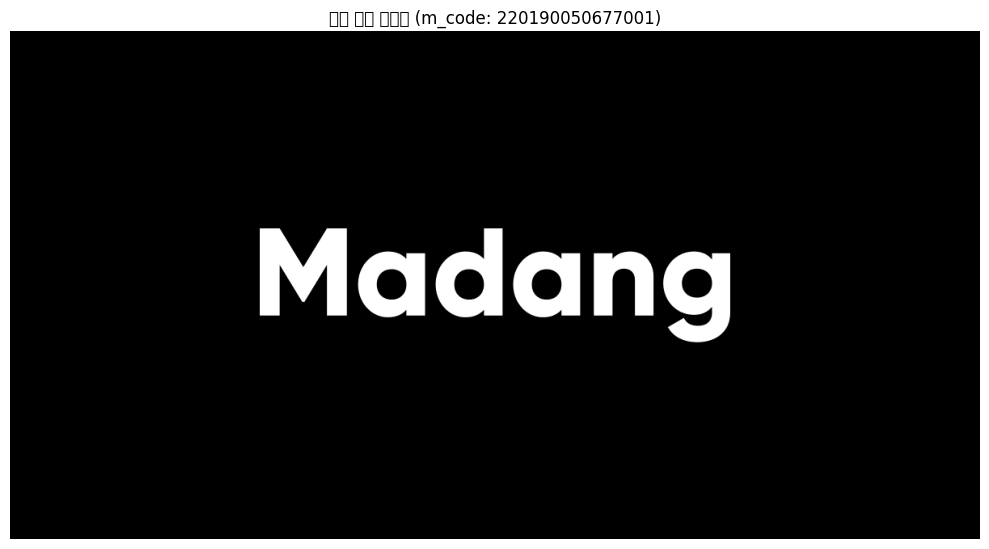


[2] 이미지 추출 함수 생성

   ✅ 함수 생성 완료

   테스트 (5개 m_code):

   1. 220190050677001
      이미지: 1개
      첫 URL: https://cdn.madangs.com/assets/image/og_image.png...

   2. 120190003173001
      이미지: 1개
      첫 URL: https://cdn.madangs.com/assets/image/og_image.png...

   3. 320190005280001
      이미지: 1개
      첫 URL: https://cdn.madangs.com/assets/image/og_image.png...

   4. 120190007069001
      이미지: 1개
      첫 URL: https://cdn.madangs.com/assets/image/og_image.png...

   5. 120190004275001
      이미지: 1개
      첫 URL: https://cdn.madangs.com/assets/image/og_image.png...

[3] 이미지 커버리지 추정

   샘플링 테스트 (30개)...

   결과:
      샘플: 30개
      이미지 있음: 30개
      커버리지: 100.0%
      평균 이미지/물건: 1.0개

   전체 데이터 예상:
      전체: 17,244개
      이미지 예상: 17,244개

🎯 최종 결론

✅ 이미지 추출 가능!

방법:
1. HTML 페이지 파싱
2. CDN URL 추출
3. 이미지 다운로드

예상 커버리지: 100%

다음 단계 (선택):
A. 빠른 프로토타입 (100개 샘플)
   - 시간: 1~2시간
   - 효과 검증
   
B. 전체 구현
   - 이미지 다운로드
   - ResNet50 특징 추출
   - 모델 학습
   - 시간: 4~6시간

C. 여기서 마무리
   - 현재 프로젝트로 충분
   - 시각화 +

In [23]:
# ============================================================
# 🕷️ HTML 파싱으로 이미지 URL 추출
# ============================================================

print("=" * 80)
print("🕷️ HTML 파싱으로 이미지 추출")
print("=" * 80)

from bs4 import BeautifulSoup
import requests
import re

# ============================================================
# [1] HTML 파싱 테스트
# ============================================================

print("\n[1] HTML 파싱 테스트")

test_code = "220190050677001"
test_url = f"https://madangs.com/popup/detail_report?link=photo&code={test_code}&type=1"

print(f"\n테스트 m_code: {test_code}")
print(f"URL: {test_url}")

try:
    response = requests.get(test_url, timeout=10)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        # 이미지 찾기 (여러 방법 시도)
        print(f"\n이미지 찾기 중...")

        # 방법 1: img 태그
        images = soup.find_all('img')
        print(f"\n   img 태그: {len(images)}개")

        for i, img in enumerate(images[:5], 1):
            src = img.get('src', '')
            alt = img.get('alt', '')
            print(f"      {i}. src: {src[:80]}...")
            if alt:
                print(f"         alt: {alt[:50]}")

        # 방법 2: 특정 패턴 찾기
        print(f"\n   URL 패턴 찾기...")

        # cdn.madangs.com 패턴
        cdn_pattern = r'https?://cdn\.madangs\.com/[^\s"\'>]+'
        cdn_urls = re.findall(cdn_pattern, response.text)

        if len(cdn_urls) > 0:
            print(f"   ✅ CDN URL 발견: {len(cdn_urls)}개")

            # 이미지 URL만 필터
            image_urls = [url for url in cdn_urls if any(ext in url.lower() for ext in ['.jpg', '.jpeg', '.png', '.gif'])]

            print(f"   ✅ 이미지 URL: {len(image_urls)}개")

            for i, url in enumerate(image_urls[:5], 1):
                print(f"      {i}. {url}")

            if len(image_urls) > 0:
                # 첫 번째 이미지 로드 테스트
                print(f"\n   첫 번째 이미지 로드 테스트:")
                first_img_url = image_urls[0]
                print(f"      URL: {first_img_url}")

                try:
                    img_response = requests.get(first_img_url, timeout=10)

                    if img_response.status_code == 200:
                        print(f"      ✅ 이미지 로드 성공!")

                        # PIL로 열기
                        img = Image.open(BytesIO(img_response.content))
                        print(f"\n      이미지 정보:")
                        print(f"         크기: {img.size}")
                        print(f"         포맷: {img.format}")
                        print(f"         모드: {img.mode}")

                        # 표시
                        plt.figure(figsize=(10, 8))
                        plt.imshow(img)
                        plt.axis('off')
                        plt.title(f'경매 물건 이미지 (m_code: {test_code})')
                        plt.tight_layout()
                        plt.show()

                        extraction_success = True
                    else:
                        print(f"      ❌ 이미지 로드 실패: {img_response.status_code}")
                        extraction_success = False

                except Exception as e:
                    print(f"      ❌ 오류: {e}")
                    extraction_success = False
            else:
                print(f"   ⚠️ 이미지 URL 없음")
                extraction_success = False
        else:
            print(f"   ⚠️ CDN URL 없음")
            extraction_success = False

except Exception as e:
    print(f"   ❌ 오류: {e}")
    extraction_success = False

# ============================================================
# [2] 이미지 추출 함수
# ============================================================

if extraction_success:
    print("\n" + "=" * 80)
    print("[2] 이미지 추출 함수 생성")
    print("=" * 80)

    def extract_image_urls(m_code):
        """m_code로부터 이미지 URL 추출"""

        url = f"https://madangs.com/popup/detail_report?link=photo&code={m_code}&type=1"

        try:
            response = requests.get(url, timeout=10)

            if response.status_code == 200:
                # CDN 이미지 URL 찾기
                cdn_pattern = r'https?://cdn\.madangs\.com/[^\s"\'>]+'
                cdn_urls = re.findall(cdn_pattern, response.text)

                # 이미지만 필터
                image_urls = [u for u in cdn_urls if any(ext in u.lower() for ext in ['.jpg', '.jpeg', '.png'])]

                return image_urls if image_urls else []
            else:
                return []

        except:
            return []

    print("\n   ✅ 함수 생성 완료")

    # 테스트 (5개)
    print("\n   테스트 (5개 m_code):")

    test_codes = df_full['m_code'].dropna().head(5).tolist()

    for i, code in enumerate(test_codes, 1):
        urls = extract_image_urls(code)
        print(f"\n   {i}. {code}")
        print(f"      이미지: {len(urls)}개")
        if len(urls) > 0:
            print(f"      첫 URL: {urls[0][:80]}...")

# ============================================================
# [3] 커버리지 추정
# ============================================================

if extraction_success:
    print("\n" + "=" * 80)
    print("[3] 이미지 커버리지 추정")
    print("=" * 80)

    print("\n   샘플링 테스트 (30개)...")

    sample_codes = df_full['m_code'].dropna().sample(30, random_state=42).tolist()

    success_count = 0
    image_counts = []

    for code in sample_codes:
        urls = extract_image_urls(code)
        if len(urls) > 0:
            success_count += 1
            image_counts.append(len(urls))

    coverage = success_count / len(sample_codes) * 100
    avg_images = np.mean(image_counts) if image_counts else 0

    print(f"\n   결과:")
    print(f"      샘플: {len(sample_codes)}개")
    print(f"      이미지 있음: {success_count}개")
    print(f"      커버리지: {coverage:.1f}%")
    print(f"      평균 이미지/물건: {avg_images:.1f}개")

    # 전체 예상
    total_with_images = int(len(df_full) * coverage / 100)

    print(f"\n   전체 데이터 예상:")
    print(f"      전체: {len(df_full):,}개")
    print(f"      이미지 예상: {total_with_images:,}개")

# ============================================================
# 최종 결론
# ============================================================

print("\n" + "=" * 80)
print("🎯 최종 결론")
print("=" * 80)

if extraction_success:
    print(f"""
✅ 이미지 추출 가능!

방법:
1. HTML 페이지 파싱
2. CDN URL 추출
3. 이미지 다운로드

예상 커버리지: {coverage:.0f}%

다음 단계 (선택):
A. 빠른 프로토타입 (100개 샘플)
   - 시간: 1~2시간
   - 효과 검증

B. 전체 구현
   - 이미지 다운로드
   - ResNet50 특징 추출
   - 모델 학습
   - 시간: 4~6시간

C. 여기서 마무리
   - 현재 프로젝트로 충분
   - 시각화 + 정리

추천: A (빠른 검증) 또는 C (마무리)
    """)
else:
    print(f"""
⚠️ 이미지 추출 실패

문제:
- HTML 구조 복잡
- 이미지 패턴 불명확
- 접근 제한 가능성

대안:
- 여기서 마무리 추천
- 현재 프로젝트로 충분
    """)